# Curve optimization with the curves library

The [curve library](https://github.com/loco-3d/curves) is a header-only C++ library (also binded in python) that allows you
to create curves, in arbitrary dimensions (2, 3, n). 
Originally, the library focused on spline curves, but it has now been extended to generic polynomials, cubic hermite splines, Bezier curves and more. 
A nice upcoming extension is the ability to design curves in the Special Euclidian group SE3.

However in this tutorial we are going to focus on a rather unique trait of the library, which is the ability to work with variable control points. Rather than being given a constant value, the control points can be expressed as the linear combination of one or several variables. The main advantage of this representation is that variable curves
can be automatically derivated or integrated with any effort. 

The other interest of variable curves is the ability to easily formulate optimization problems, which will be the focus of this tutorial. We will use the python bindings of the curve library to go step-by-step to formulating and solving an optimization problem.

## The problem: trajectory fitting

We start with a simple, unconstrained problem. 

Let us first consider a 3D curve:

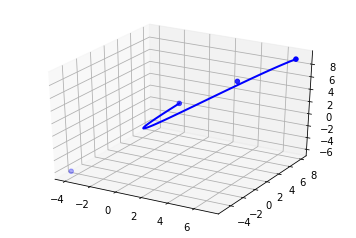

In [10]:
# importing classical numpy objects
from numpy import zeros, array, identity, dot
from numpy.linalg import norm
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}".format(x)})

#use array representation for binding eigen objects to python
import eigenpy
eigenpy.switchToNumpyArray()

#importing the bezier curve class
from curves import (bezier)

#importing tools to plot bezier curves
from plot_bezier import plotBezier
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

#We describe a degree 3 curve as a Bezier curve with 4 control points
waypoints = array([[1., 2., 3.], [-4., -5., -6.], [4., 5., 6.], [7., 8., 9.]]).transpose()
ref = bezier(waypoints)

#plotting the curve with its control points
plotBezier(ref,showControlPoints = True)
plt.show()

We now assume that we only have partial information about this curve, and that we want to reconstruct it.

We will first generate a discretization of the curve to represent a temporal sampling:

In [2]:
numSamples = 10; fNumSamples = float(numSamples)
ptsTime = [ (ref(float(t) / fNumSamples), float(t) / fNumSamples) for t in range(numSamples+1)]
for el in ptsTime:
    print el

(array([1.0, 2.0, 3.0]), 0.0)
(array([-0.1, 0.4, 0.9]), 0.1)
(array([-0.6, -0.4, -0.1]), 0.2)
(array([-0.5, -0.4, -0.2]), 0.3)
(array([0.1, 0.2, 0.4]), 0.4)
(array([1.0, 1.2, 1.5]), 0.5)
(array([2.2, 2.6, 3.0]), 0.6)
(array([3.4, 4.1, 4.7]), 0.7)
(array([4.7, 5.6, 6.4]), 0.8)
(array([6.0, 6.9, 7.9]), 0.9)
(array([7.0, 8.0, 9.0]), 1.0)


Each entry of ptsTime is a couple (position, time) that describes our input data.

### Sanity check
Let's first solve a trivial problem, to see if we can reconstruct the curve with a polynomial
of same degree.
To achieve this we will use the problemDefinition class, which will automatically generate the variable expression of the curve

In [3]:
from curves.optimization import (problem_definition, setup_control_points)

#dimension of our problem (here 3 as our curve is 3D)
dim = 3
refDegree = 3
pD = problem_definition(dim)
pD.degree = refDegree #we want to fit a curve of the same degree as the reference curve for the sanity check

#generates the variable bezier curve with the parameters of problemDefinition
problem = setup_control_points(pD)
#for now we only care about the curve itself
variableBezier = problem.bezier()

The evaluation of a variable Bezier returns a matrix A and a vector b, such 
that A x + b , with x a vector variable, defines the value of the curve

In [4]:
linearVariable = variableBezier(0.)
print "A: \n", linearVariable.A
print "b:\n",linearVariable.b
print "Shape of A: ", linearVariable.A.shape

A: 
[[1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]]
b:
[0.0 0.0 0.0]
Shape of A:  (3, 12)


A has 3 rows and 12 columns. Because the fitting curve is of degree 3, it has 4 control points of dimension 3, which gives a variable of size 12. The row number also matches the dimension of the problem.
Then A is zero everywhere, expect for the first 3 columns that contain the identity. This is expected as the start of a Bezier curve is equal to the first control point.

If we evaluate variableBezier at t = 0.2 for instance, we get a more complex expression:

In [5]:
print "A: \n", variableBezier(0.2).A

A: 
[[0.5 0.0 0.0 0.4 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.5 0.0 0.0 0.4 0.0 0.0 0.1 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.5 0.0 0.0 0.4 0.0 0.0 0.1 0.0 0.0 0.0]]


With variableBezier, we can easily define a least square problem to reconstruct the original curve.
We just have to formulate a cost function that, for each sample in ptsTime minimizes the distance between the evaluation of variableBezier and the sampled point. We define it as follows:

In [6]:
#least square form of ||Ax-b||**2 
def to_least_square(A, b):
    return dot(A.T, A), - dot(A.T, b)

#first evaluate variableBezier for each time sampled
allsEvals = [(variableBezier(time), pt) for (pt,time) in ptsTime]
#then compute the least square form of the cost for each points
allLeastSquares = [to_least_square(el.A, el.b + pt) for (el, pt) in  allsEvals]
#and finally sum the costs
Ab = [sum(x) for x in zip(*allLeastSquares)]
A = Ab[0]; b = Ab[1]

Here we use quadprog to solve the least square. Because there are no constraint this might seem overkill, however we will introduce them soon enough.

In [7]:
from qp import quadprog_solve_qp

res = quadprog_solve_qp(A, b)

Let's check whether our optimization worked !
We can transform the variable Bezier as a regular Bezier curve as follows, and plot the result to verify that the curves match.

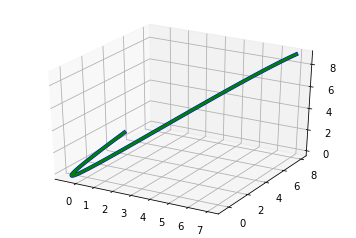

In [8]:
fitBezier = variableBezier.evaluate(res.reshape((-1,1)) ) 

#plot reference curve in blue, fitted curve in green
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")  
plotBezier(ref, ax = ax, linewidth=4.) #thicker line to visualize overlap
plotBezier(fitBezier, ax = ax, color ="g", linewidth=3.) 
plt.show()

We can try to fit the reference curve with a curve of lesser degree

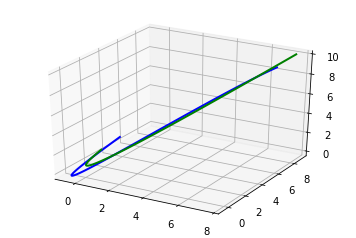

In [9]:
#defining a python method to encapsulate the fitting
def simplefit(degree):
    pD = problem_definition(dim)
    pD.degree = degree 
    #generates the variable bezier curve with the parameters of problemDefinition
    problem = setup_control_points(pD)
    #for now we only care about the curve itself
    variableBezier = problem.bezier()
    allsEvals = [(variableBezier(time), pt) for (pt,time) in ptsTime]
    #then compute the least square form of the cost for each points
    allLeastSquares = [to_least_square(el.A, el.b + pt) for (el, pt) in  allsEvals]
    #and finally sum the costs
    Ab = [sum(x) for x in zip(*allLeastSquares)]
    res = quadprog_solve_qp(Ab[0], Ab[1])
    fitBezier = variableBezier.evaluate(res.reshape((-1,1)) ) 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")  
    plotBezier(ref, ax = ax) #thicker line to visualize overlap
    plotBezier(fitBezier, ax = ax, color ="g") 
    plt.show()
    
simplefit(refDegree-1)